## Data

In [470]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, make_scorer, cohen_kappa_score
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [432]:
df_heart = pd.read_csv('./Data/heart_attack.csv')
df_heart.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [433]:
cat = ['sex', 'cp', 'restecg']
df_heart[cat] = df_heart[cat].astype('object')

df_heart.describe()

,age,trtbps,chol,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,132.098901,246.860806,149.446886,0.534799
std,9.163134,17.700358,52.569726,23.240707,0.499704
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.000000,120.000000,211.000000,133.000000,0.000000
50%,56.000000,130.000000,240.000000,152.000000,1.000000
75%,61.000000,140.000000,275.000000,166.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,1.000000


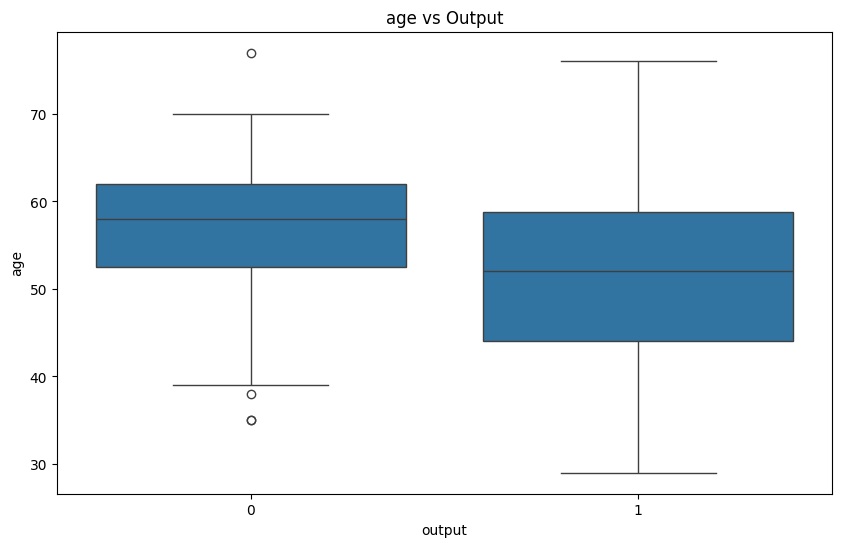

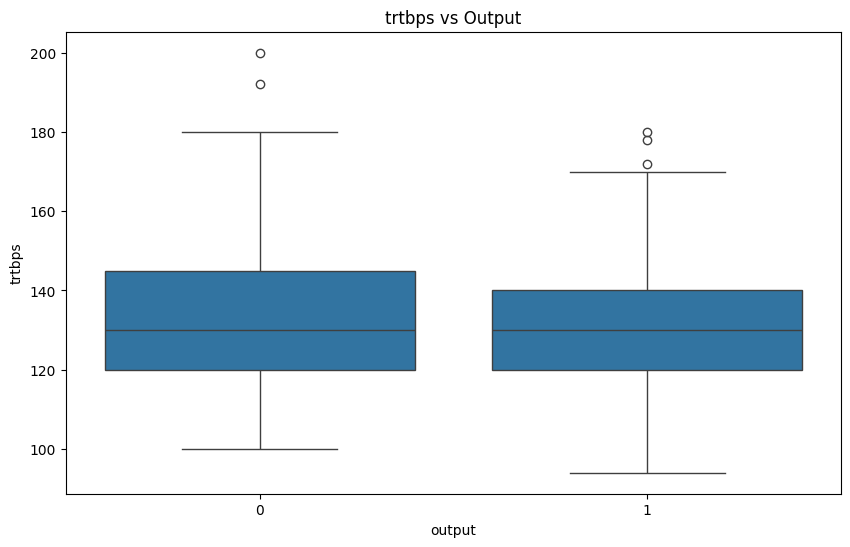

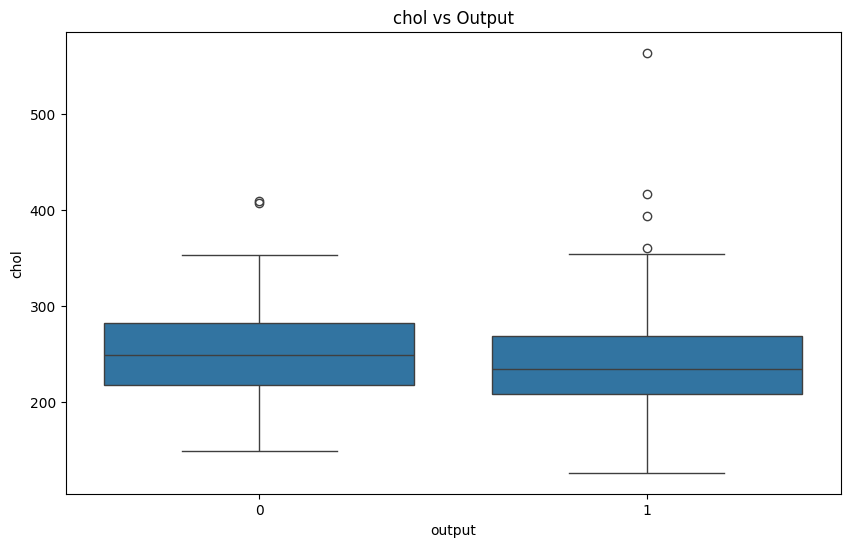

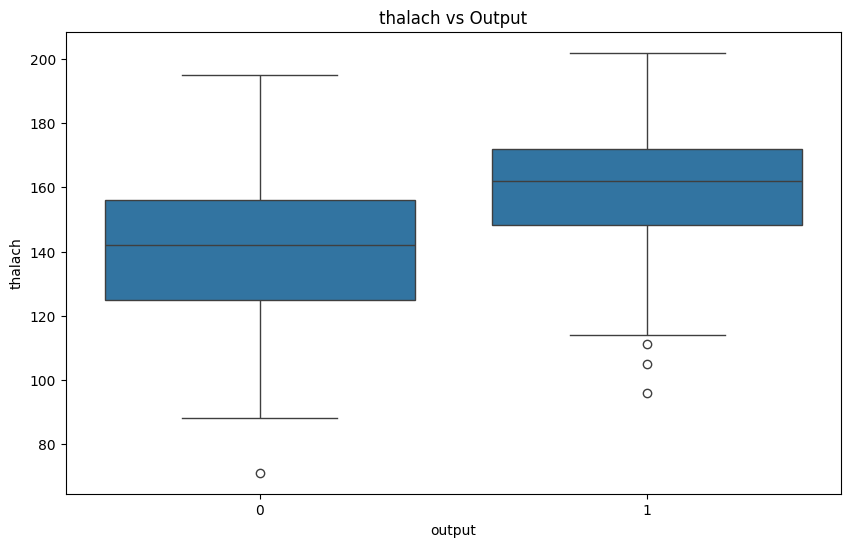

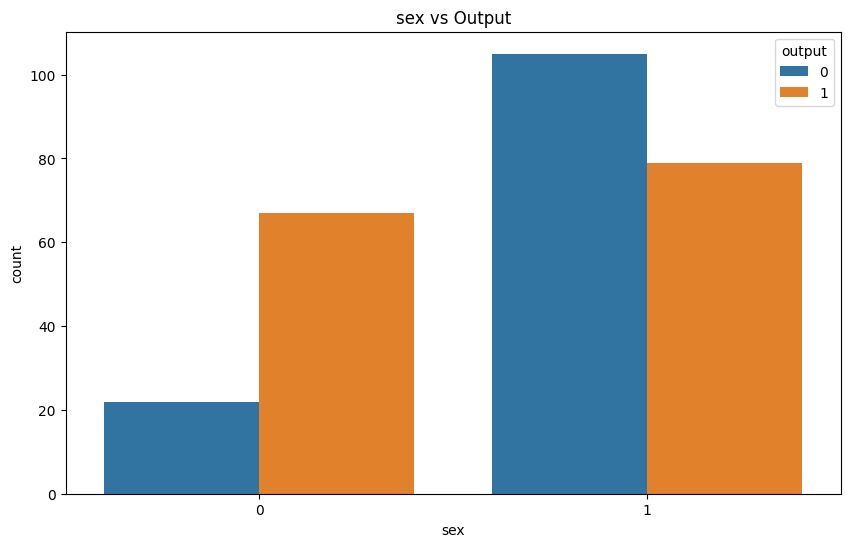

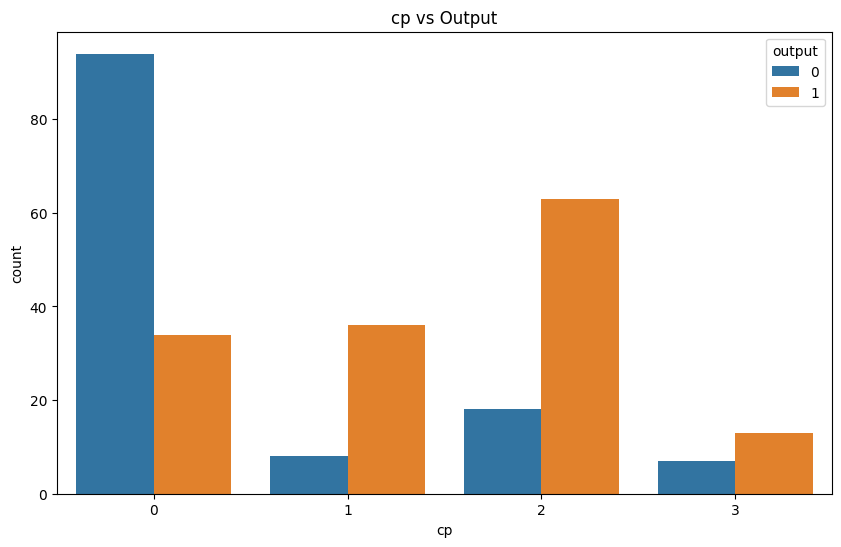

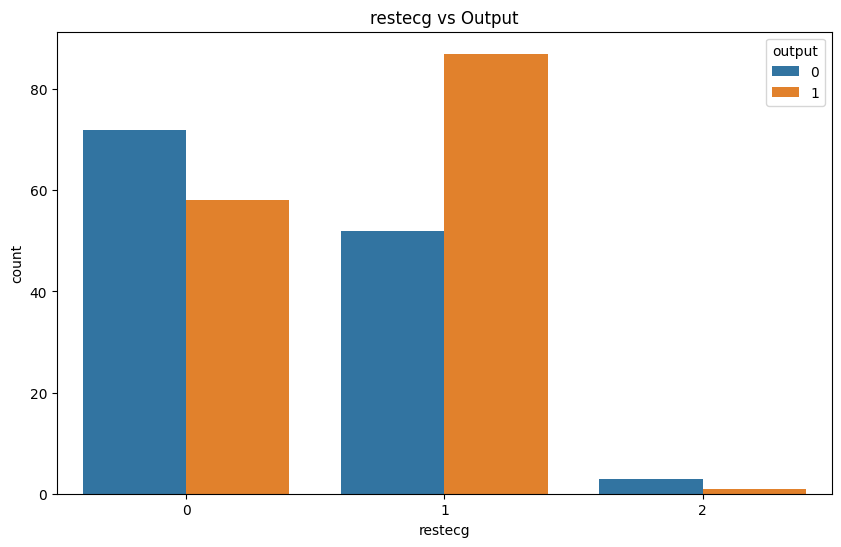

In [434]:
num = ['age', 'trtbps', 'chol', 'thalach']
cat = ['sex', 'cp', 'restecg']

for feature in num:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='output', y=feature, data=df_heart)
    plt.title(f'{feature} vs Output')
    plt.show()

for feature in cat:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='output', data=df_heart)
    plt.title(f'{feature} vs Output')
    plt.show()

## Part One: Fitting Models

In [455]:
X = df_heart.drop(columns=['output'])
y = df_heart['output']

In [436]:
ct = ColumnTransformer(
    [("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
     ("cat", OneHotEncoder(), make_column_selector(dtype_include=object))]
)

pipeline_knn = Pipeline(
    [("preprocessing", ct),
     ("kNN", KNeighborsClassifier())]
)

pipeline_log = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())]
)

pipeline_tree = Pipeline(
    [("preprocessing", ct),
     ("tree", DecisionTreeClassifier())]
)

In [437]:
dropped_features = {
    "all": X,
    "age": X.drop(columns=['age']),
    "trtbps": X.drop(columns=['trtbps']),
    "chol": X.drop(columns=['chol']),
    "thalach": X.drop(columns=['thalach']),
    "sex": X.drop(columns=['sex']),
    "cp": X.drop(columns=['cp']),
    "restecg": X.drop(columns=['restecg'])
}

In [438]:
def best_features(pipeline, params, features, y):
    scores_dict = {}

    for set_num, X in features.items():
        grid_search = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc')
        grid_search.fit(X, y)
        scores_dict[set_num] = grid_search.best_score_
    
    return sorted(scores_dict.items(), key=lambda x: x[1])


In [439]:
param_grid_knn = {
    'kNN__n_neighbors': [3, 5, 7, 10],
    'kNN__weights': ['uniform', 'distance'],
    'kNN__metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_log = {
    'log__C': [0.01, 0.1, 1, 10, 100]
}

param_grid_tree = {
    'tree__max_depth': [3, 5, 10, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4],
    'tree__max_features': ['auto', 'sqrt', 'log2', None]
}

In [441]:
best_features(pipeline_knn, param_grid_knn, dropped_features, y)

[('sex', 0.7661623342175067),
 ('cp', 0.7808488063660477),
 ('age', 0.8032703801945182),
 ('thalach', 0.8081920424403183),
 ('chol', 0.8250907161803713),
 ('all', 0.8258532272325375),
 ('trtbps', 0.8334213969938109),
 ('restecg', 0.8446938992042441)]

In [ ]:
best_features(pipeline_log, param_grid_log, dropped_features, y)

[('cp', 0.8086394341290892),
 ('sex', 0.8140993810786915),
 ('thalach', 0.8444258178603006),
 ('trtbps', 0.8580916003536693),
 ('chol', 0.8607908045977013),
 ('all', 0.864367816091954),
 ('age', 0.8692725022104332),
 ('restecg', 0.8713174182139699)]

In [ ]:
best_features(pipeline_tree, param_grid_tree, dropped_features, y)

[('cp', 0.7604268788682582),
 ('sex', 0.7813039787798409),
 ('all', 0.7997188328912467),
 ('age', 0.8064838196286473),
 ('thalach', 0.8134001768346595),
 ('trtbps', 0.8146054818744475),
 ('chol', 0.817478691423519),
 ('restecg', 0.8175706454465075)]

In [ ]:
feature_sets = {
    1: X,
    2: X.drop(columns=['trtbps']),
    3: X.drop(columns=['chol']),
    4: X.drop(columns=['restecg']),
    5: X.drop(columns=['trtbps', 'chol']),
    6: X.drop(columns=['trtbps', 'restecg']),
    7: X.drop(columns=['chol', 'restecg']),
    8: X.drop(columns=['trtbps', 'chol', 'restecg'])
}

In [ ]:
def best_model(pipeline, params, features, y):
    best_score = -1
    best_params = None
    best_feature_set = None

    for set_num, X in features.items():
        grid_search = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc')
        grid_search.fit(X, y)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_
            best_feature_set = set_num

    return best_feature_set, best_params, best_score

### kNN

In [ ]:
best_model(pipeline_knn, param_grid_knn, feature_sets, y)

(8,
 {'kNN__metric': 'manhattan',
  'kNN__n_neighbors': 10,
  'kNN__weights': 'uniform'},
 0.85241308576481)

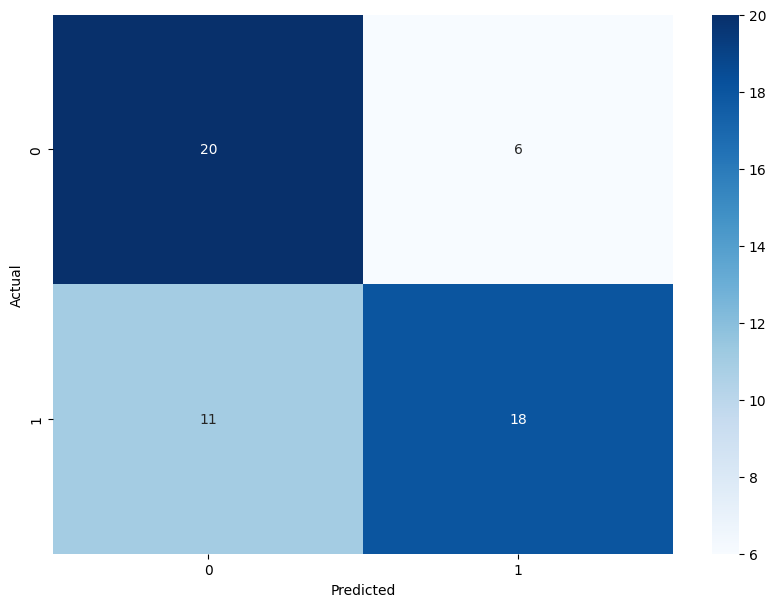

In [442]:
X_train, X_test, y_train, y_test = train_test_split(feature_sets.get(8), y, test_size=0.2, random_state=42)

pipeline_knn.set_params(kNN__metric='manhattan', kNN__n_neighbors=10, kNN__weights='uniform')
pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)

y_prob = pipeline_knn.predict_proba(feature_sets.get(8))[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y, y_prob)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Logistic

In [444]:
best_model(pipeline_log, param_grid_log, feature_sets, y)

(4, {'log__C': 1}, 0.8713174182139699)

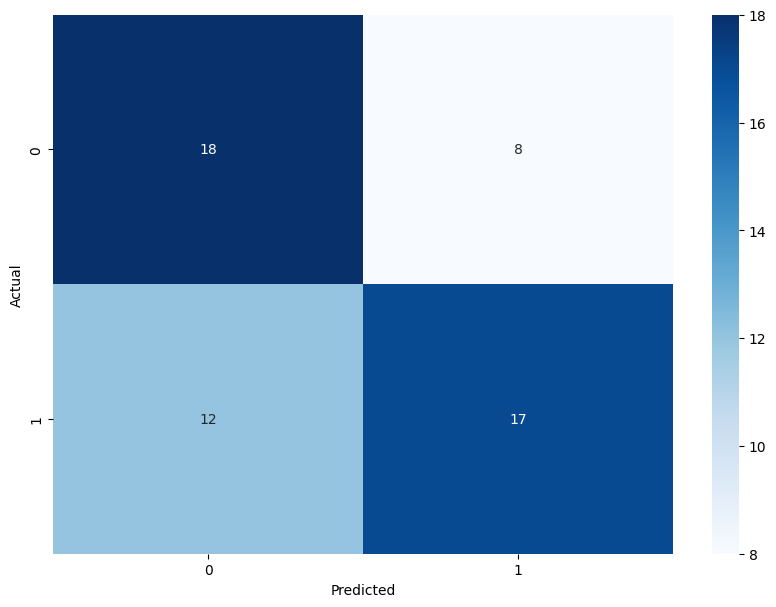

In [445]:
X_train, X_test, y_train, y_test = train_test_split(feature_sets.get(4), y, test_size=0.2, random_state=42)

pipeline_log.set_params(log__C=1)
pipeline_log.fit(X_train, y_train)
y_pred = pipeline_log.predict(X_test)

y_prob = pipeline_log.predict_proba(feature_sets.get(4))[:, 1]
fpr_log, tpr_log, _ = roc_curve(y, y_prob)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Tree

In [446]:
best_model(pipeline_tree, param_grid_tree, feature_sets, y)

(5,
 {'tree__max_depth': 3,
  'tree__max_features': 'sqrt',
  'tree__min_samples_leaf': 1,
  'tree__min_samples_split': 10},
 0.8402093722369584)

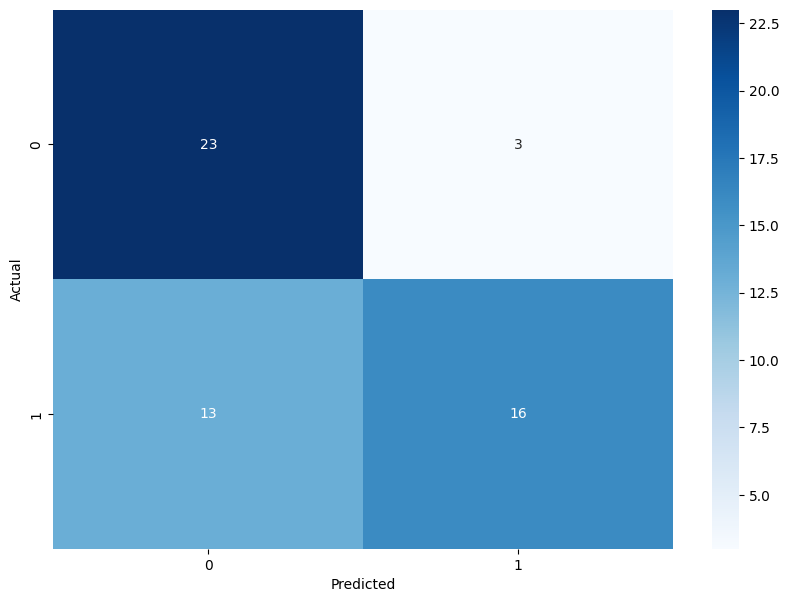

In [447]:
X_train, X_test, y_train, y_test = train_test_split(feature_sets.get(5), y, test_size=0.2, random_state=42)

pipeline_tree.set_params(tree__max_depth=3, tree__max_features='sqrt', tree__min_samples_leaf=1, tree__min_samples_split=10)
pipeline_tree.fit(X_train, y_train)
y_pred = pipeline_tree.predict(X_test)

y_prob = pipeline_tree.predict_proba(feature_sets.get(5))[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y, y_prob)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From testing, I found that the most important metrics for predicting outcome are sex and cp, with age and thalach also being important.

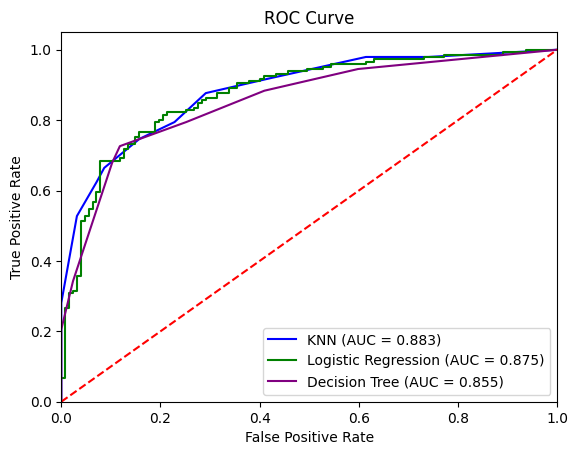

In [448]:
roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.plot(fpr_knn, tpr_knn, color='blue', label=f'KNN (AUC = {roc_auc_knn:.3f})')
plt.plot(fpr_log, tpr_log, color='green', label=f'Logistic Regression (AUC = {roc_auc_log:.3f})')
plt.plot(fpr_tree, tpr_tree, color='purple', label=f'Decision Tree (AUC = {roc_auc_tree:.3f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Part Two: Metrics

In [449]:
models = {
    "kNN": (pipeline_knn, X.drop(columns=['trtbps', 'chol', 'restecg'])),
    "Logistic": (pipeline_log, X.drop(columns=['restecg'])),
    "Decision Tree": (pipeline_tree, X.drop(columns=['trtbps', 'chol']))
}

def specificity_score(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return specificity

precision_scorer = make_scorer(precision_score, zero_division=0)
specificity_scorer = make_scorer(specificity_score)

results = {}
for name, model in models.items():
    recall = cross_val_score(model[0], model[1], y, cv=5, scoring='recall').mean()
    precision = cross_val_score(model[0], model[1], y, cv=5, scoring=precision_scorer).mean()
    specificity = cross_val_score(model[0], model[1], y, cv=5, scoring=specificity_scorer).mean()
    results[name] = {'Recall': recall, 'Precision': precision, 'Specificity': specificity}

for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    print()

Model: kNN
Recall: 0.73
Precision: 0.86
Specificity: 0.86

Model: Logistic
Recall: 0.83
Precision: 0.80
Specificity: 0.75

Model: Decision Tree
Recall: 0.73
Precision: 0.77
Specificity: 0.68



## Part Three: Discussion

Minimize false negatives: recall should be primary metric\
I would use my Logistic Regression model since it has the highest recall metric\
I would expect recall to be around my 0.83 for future predictions, maybe slightly lower due to variability with unseen data

Minimize false positives: precsion should be primary metric\
I would use my kNN model since it has the highest precision metric\
I would expect precision to be around 0.86 for future predictions, maybe slighlty lower due to variability with unseen data

Balanced metric: ROC-AUC should be primary metric\
I would use my Logistic Regression model since it has the highest AUC score between that and my Logistic Regression. It is between these 2 since they are interpritable, unlike kNN.\
I would expect AUC to be around 0.87 for future predicitons, maybe slightly lower due to variability with unseen data

Simple metric: accuracy should be the primary metric\
I would use either Logistic Regression or Decision Tree model, whichever has higher accuracy due to their simplicity and interpritability.\
I would expect accuracy to be around my testing accuracy for future predictions, maybe slightly lower due to variability with unseen data

## Part Four: Validation

In [450]:
df_heart_valildation = pd.read_csv('./Data/heart_attack_validation.csv')
df_heart_valildation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [451]:
df_heart_valildation[cat] = df_heart_valildation[cat].astype('object')

df_heart_valildation.describe()

,age,trtbps,chol,thalach,output
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,54.533333,127.300000,240.833333,151.466667,0.633333
std,8.451620,15.592107,44.962117,19.842020,0.490133
min,40.000000,100.000000,131.000000,111.000000,0.000000
25%,48.000000,113.500000,205.750000,143.250000,0.000000
50%,54.500000,130.000000,245.000000,155.000000,1.000000
75%,59.000000,139.500000,272.500000,162.000000,1.000000
max,71.000000,160.000000,330.000000,182.000000,1.000000


In [454]:
X_test = df_heart_valildation.drop(columns=['output'])
y_test = df_heart_valildation['output']

In [471]:
def model_metrics(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    y_prob = pipeline.predict_proba(X_test)[:, 1]
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr_knn, tpr_knn)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"AUC: {roc_auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")

### kNN

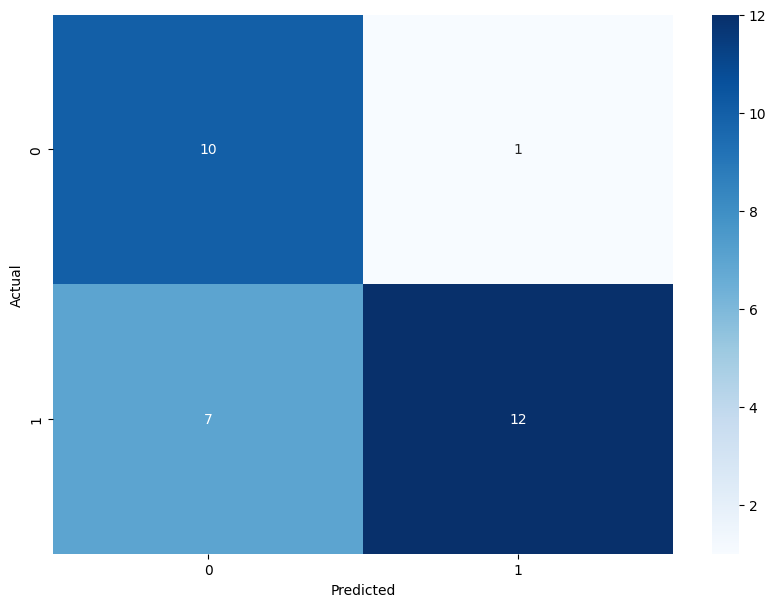

AUC: 0.871
Precision: 0.923
Recall: 0.632


In [472]:
X_knn = X_test.drop(columns=['trtbps', 'chol', 'restecg'])

model_metrics(pipeline_knn, feature_sets.get(8), y, X_knn, y_test)

### Logistic

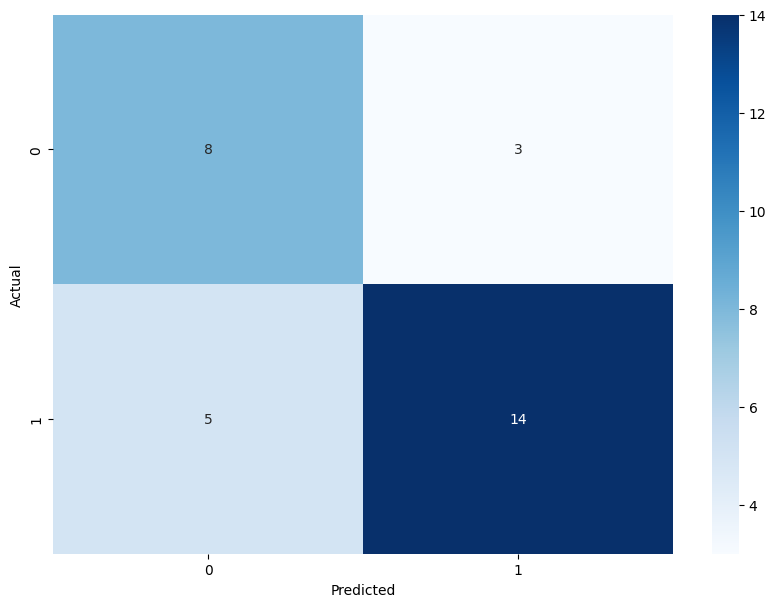

AUC: 0.890
Precision: 0.824
Recall: 0.737


In [474]:
X_log = X_test.drop(columns=['restecg'])

model_metrics(pipeline_log, feature_sets.get(4), y, X_log, y_test)

### Tree

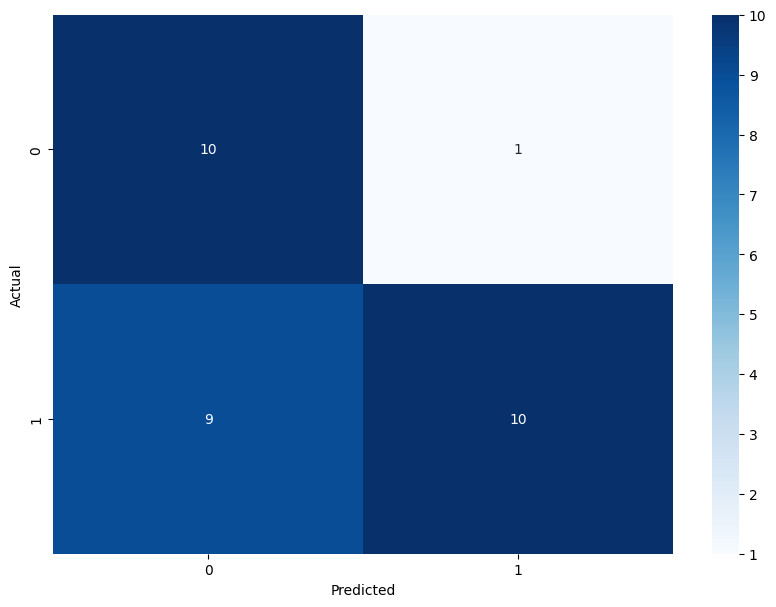

AUC: 0.679
Precision: 0.909
Recall: 0.526


In [475]:
X_tree = X_test.drop(columns=['trtbps', 'chol'])

model_metrics(pipeline_tree, feature_sets.get(5), y, X_tree, y_test)

My validation metrics were much higher in some areas and much lower in some areas. Most notably, the recalls for my models were worse, and the precisions for my models were better. The AUC's were similar, except for the Decision Tree modelm, which had a significant decrease from Part 1. This is most likely due to the small sample size in the validation set (only 30 observations).

## Part Five: Cohen’s Kappa

In [510]:
pipeline_knn.fit(feature_sets.get(8), y)
y_pred_knn = pipeline_knn.predict(X_knn)

pipeline_log.fit(feature_sets.get(4), y)
y_pred_log = pipeline_log.predict(X_log)

pipeline_tree.fit(feature_sets.get(5), y)
y_pred_tree = pipeline_tree.predict(X_tree)

kappa_knn = cohen_kappa_score(y_test, y_pred_knn)
kappa_logistic = cohen_kappa_score(y_test, y_pred_log)
kappa_tree = cohen_kappa_score(y_test, y_pred_tree)

print("Kappa for kNN:", kappa_knn)
print("Kappa for Logistic Regression:", kappa_logistic)
print("Kappa for Decision Tree:", kappa_tree)

Kappa for kNN: 0.4849785407725322
Kappa for Logistic Regression: 0.4470046082949308
Kappa for Decision Tree: 0.6


I might want to consider Cohen's Kappa score with my models, since each uses a different set of features. Also it would be useful for a dataset with inbalanced classes (not the case here though). If I use this metric, my Decision Tree model seems to be the best. This makes sense, as input data goes through many levels, which would make random agreement a lower probability than kNN or logistic regression.